# Cart and Pole Problem - No Optimization
Example of running the cart and pole environment for 1000 time steps using no optimzation, no instructions for when to end an episode, and choosing a random action at each time step. The screen will be rendered at each time step.

Code taken from here:

https://www.youtube.com/watch?v=FU-sNVew9ZA&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv&index=15

https://deeplizard.com/learn/video/PyQNfsGUnQA

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

Other solutions:

https://gym.openai.com/envs/CartPole-v0/


In [1]:
import gym
env = gym.make('CartPole-v0')
env.reset()

#render the env to see how it looks like
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample())
env.close()

C:\Users\Lucia\Anaconda3\envs\gym\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Cart and Pole Deep Q-Network Project
The original tutorial for which this project is based is located at the link below. I have made several modifications throughout.

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html


## Import Libraries

In [2]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## Set up display

To display images

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

## Deep Q-Network

Strategy:

1. Use pyTorch class and build a child class to inherit the parent's class methods (and extend it)
2. The inputs are the game's images
3. Build 2 fully connected layers (i.e. "linear layers") and one output layer
4. Get outputs according to each possible action on a given state. In our case, we can only move left or right 
so we'll have 2 possible actions per state, thus we need 2 outputs from the layer.
5. Implement 'forward' - > fwd pass to the network layers.


In [4]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
         
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)#'3' = RGB, num of outputs = arbitrary
        self.fc2 = nn.Linear(in_features=24, out_features=32) #number of outputs of first layer = num of inputs of the second
        self.out = nn.Linear(in_features=32, out_features=2)  #number of outputs = num of possible actions on state          

    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## Experience container

Create 'experiences' object to store the data required to train the NN

In [5]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

## Replay Memory

Here the main parameter is the 'capacity' of the "Replay memory" which is used to store 'experiences'.

It is arbitrary.

In [6]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity   = capacity
        self.memory     = [] #container to store the experiences
        self.push_count = 0 #counter of experiences added to memory
    
     #If capacity allows, store a new Experience (i.e. 'push to memory')
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience #override oldest experiences
        self.push_count += 1

    #Sample experiences randomly from memory  
    #'batch size' - > how many experiences we want to retrieve
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    #Apply security in case 'batch size' passed > than memory available
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Epsilon Greedy Strategy

Define epsilon - Exploration rate (prob of explore new states)

The strategy is to decay the exploration rate as we play each game (since we know more abt the environment)

In [7]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start #epsilon start value
        self.end   = end   #epsilon end value 
        self.decay = decay #epsilon decaye value
    
    #calculate exploration rate parameter
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

## RL Agent

Strategy:

1. Pass in the greedy strategy and how many actions it can take on a given state (for us is 2 = left, right)
2. Return an 'action' given the greedy strategy policy

In [8]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0 #current step number in the environment
        self.strategy     = strategy
        self.num_actions  = num_actions
        self.device       = device #device used by Pytorch for the tensor calculation (GPU or CPU)

    #define action basecd on input from the policy network    
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step) #epsilon-greedy rate
        self.current_step += 1

        #Define to explore-exploit based on a threshold  
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad(): #turn off gradient tracking as we are not training, just inference
                return policy_net(state).argmax(dim=1).to(self.device) # exploit based on highest Qval for given state (from policy network)

## Environment Manager

Strategy:
Perform image pre-processing to pass to gymIA's environment manager


In [9]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env    = gym.make('CartPole-v0').unwrapped  #we want some 'behind the scenes data'
        self.env.reset()  #reset env to get an initial observation
        self.current_screen = None #'None' means that we haven't yet rendered the screen of any observation since we are at the start of the game
        self.done = False #vble used to track whether an action has ended the episode
    
    #Reset environment to a starting state. Function will return an initial obs from env.
    def reset(self):
        self.env.reset()
        self.current_screen = None #at the end of an episode there is no screen to render
     
   #Close environment 
    def close(self):
        self.env.close()
    
    #Render current state of the Env to the current screen.
    def render(self, mode='human'):
        return self.env.render(mode)
     
    #How many actions are available in the current env (for us this is 2, left or right) 
    def num_actions_available(self):
        return self.env.action_space.n
        
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item()) #call Gym and store only the variable of interest from the tuple it returns
        return torch.tensor([reward], device=self.device) #return reward and device used (GPU vs CPU)
    
    def just_starting(self):
        return self.current_screen is None #either we have started or we are at the end of an episode
    
    #Get the state of environment in the form of a processed image of the screen
    # (states are represented as screen-shot like images)
    # the image representation is the difference btw the current and previous screen, since we want to calculate velocity of pole
    def get_state(self):
        if self.just_starting() or self.done:  #initial case, when there is no previous screen to compare to, .....
            self.current_screen = self.get_processed_screen() #so representation is a fully black screen
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2 #update the values between current and previous screen
            return s2 - s1  #diff between current screen and last screen
        
    #Get screen dimentions
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
     
    #Process screen into an RGB array, crops, rescales    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom - to remove empty white space coming form Gym.
        top    = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    #Rescale and transform from np array to tensor
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255  #rescale 
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms - resize
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90)) #this is the batch dimension, since the image will be processed in batches
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

## Example of non-processed screen

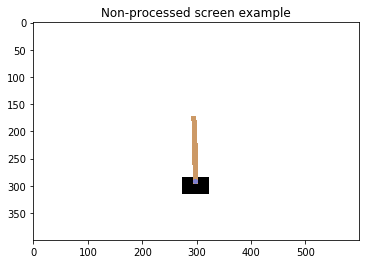

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

## Example of processed screen

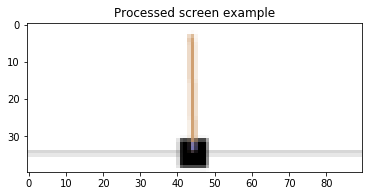

In [11]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

## Example of starting state

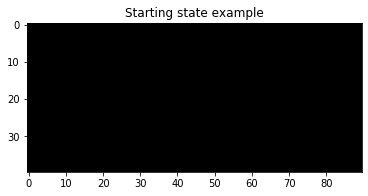

In [12]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

## Example of non-starting state

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


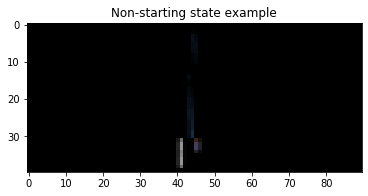

In [13]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non-starting state example')
plt.show()

## Example of end state

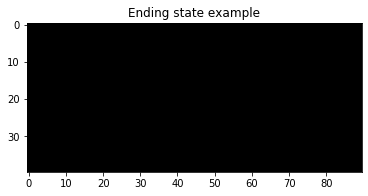

In [14]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

## Utility functions

### Plotting

In [15]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    
    #Print moving average of episodes!
    print("Episode", len(values), "\n", \
          moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

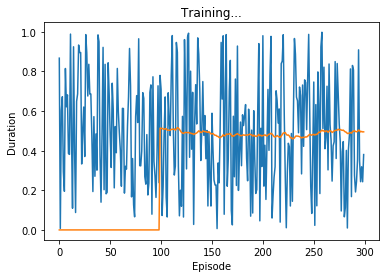

Episode 300 
 100 episode moving avg: 0.49509475


In [16]:
plot(np.random.rand(300), 100) #in yellow, the 100 values of the moving average

### Tensor processing

In [17]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

#### Example of Experience(\*zip(\*experiences)) used above
See https://stackoverflow.com/a/19343/3343043 for further explanation.

In [18]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [19]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

### Q-Value Calculator
Class to calculate the Q vals for the current state policy net and the next state using the target net.

Find out whether we have any final state in our next state.
If we do, we need to find their location so we don't pass them to the target NN (as we know they are zeros)

From here:

https://www.youtube.com/watch?v=ewRw996uevM&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv&index=18

In [20]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod # we can call these methods without creating an instance of the class first.
    #Get data from Replay Memory and return the predicted Q values from the policy net
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    #Get max Q val predicted by the target net (among all possible next actions)
    @staticmethod        
    def get_next(target_net, next_states):  
        #find location of all final states (final state = no reward and black screen)
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0] #batch size = how many states are in the next state tensor
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

## Main Program

In [21]:
#Initialize hyper parameters
batch_size    = 256
gamma         = 0.999 #discount factor for Bellman eqn
eps_start     = 1     #starting value of epsilon (exloration rate)
eps_end       = 0.01  #end value of epsilon
eps_decay     = 0.001 #epsilon decay
target_update = 10    #How frequently (in terms of episodes) we update the value of the Target NN weights with the policy NN weights
memory_size   = 100000 #capacity of replay memory
lr            = 0.001  #learning rate
num_episodes  = 1000
   
#Initialize objects instances    
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em       = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent    = Agent(strategy, em.num_actions_available(), device)
memory   = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict()) #dimensions of policy net = dim of target net
target_net.eval() #to set this network not in training mode (only used for inference)
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) #Use Adam optimizer


####################################################################################################
# Start the training
#################################################################################################

episode_durations = [] #store the duration to plot the episodes

for episode in range(num_episodes):
    em.reset()
    state = em.get_state() #get initial state
    
    for timestep in count():
        action = agent.select_action(state, policy_net) #we pass policy net as it's used by the agent if it explores env
        reward = em.take_action(action) #get a reward from Gym
        next_state = em.get_state()     #get the next state based on the action taken
        memory.push(Experience(state, action, next_state, reward)) #build the "experience" tuple and push to Replay memory
        state = next_state #transition to next state

        #Train the policy net based on the sample take from Replay Memory
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            #Get all the Qvalues for the Experiences passed as predicted by the Policy NN
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values    = QValues.get_next(target_net, next_states) #max Q value of the next state
            target_q_values  = (next_q_values * gamma) + rewards #apply formula
            #Calculate the loss of the NN as the difference between current and target Qfuncts
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad() #zero out to avoid accumulation
            loss.backward() #gradients of loss
            optimizer.step()
        
        #check if last action has ended the Episode
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break #brake current and start a new episode
    
    #Check whether we should update our target net. We see if we are in a multiple of 10 (we update every 10 episodes)
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
em.close() #end if we have set the number of episodes

KeyboardInterrupt: 